# Ultimate Inc Data Science Challenge

In [23]:
# Import necessary packages
import json
from pandas.io.json import json_normalize
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import datetime
from tqdm import tqdm
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np

# Part 1: Exploratory data analysis

In [24]:
# Read Data
with open('D:\VirajScripts\misc_2\logins.json') as f:
    data_json = json.load(f)

logins_df = pd.DataFrame(data_json)
logins_df['login_time'] = pd.to_datetime(logins_df['login_time'], errors='coerce')
print(logins_df.info())
display(logins_df.head())
print('Max value of login_time is {}'.format(max(logins_df.login_time)))
print('Min value of login_time is {}'.format(min(logins_df.login_time)))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None


,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


Max value of login_time is 1970-04-13 18:57:38
Min value of login_time is 1970-01-01 20:12:16


Initial data extraction as seen above, from logins.json shows that there are a total of >90K entries of logins between Jan 1st and April 13th

In [25]:
# group the entire dataframe with 15 minute intervals
full_grouped_15min = pd.DataFrame(logins_df.groupby(pd.Grouper(key='login_time', freq='15Min')).size()).reset_index()
full_grouped_15min.columns = ['login_time', 'count_time']
display(full_grouped_15min.head(10))

,login_time,count_time
0,1970-01-01 20:00:00,2
1,1970-01-01 20:15:00,6
2,1970-01-01 20:30:00,9
3,1970-01-01 20:45:00,7
4,1970-01-01 21:00:00,1
5,1970-01-01 21:15:00,4
6,1970-01-01 21:30:00,0
7,1970-01-01 21:45:00,4
8,1970-01-01 22:00:00,9
9,1970-01-01 22:15:00,8


In [26]:
#bin by minutes of the day
logins_df['days_minutes'] = pd.to_datetime(logins_df['login_time'],format='%H:%M:%S').dt.hour*60 + \
                            pd.to_datetime(logins_df['login_time'],format='%H:%M:%S').dt.minute
minutes_bin = list(range(0, 24*60, 15))
day_grouped_15min = pd.DataFrame(pd.cut(logins_df['days_minutes'], bins=minutes_bin).value_counts(sort=False)).reset_index()
day_grouped_15min.columns = ['bin_interval', 'count_time']
day_grouped_15min['bin_max'] = day_grouped_15min['bin_interval'].apply(lambda x: x.right)
day_grouped_15min['HH:MM'] = day_grouped_15min['bin_max'].apply(lambda x: '{:02d}:{:02d}'.format(*divmod(x, 60)))

display(day_grouped_15min)

,bin_interval,count_time,bin_max,HH:MM
0,"(0, 15]",1462,15,00:15
1,"(15, 30]",1533,30,00:30
2,"(30, 45]",1508,45,00:45
3,"(45, 60]",1503,60,01:00
4,"(60, 75]",1564,75,01:15
5,"(75, 90]",1596,90,01:30
6,"(90, 105]",1665,105,01:45
7,"(105, 120]",1496,120,02:00
8,"(120, 135]",1505,135,02:15
9,"(135, 150]",1496,150,02:30


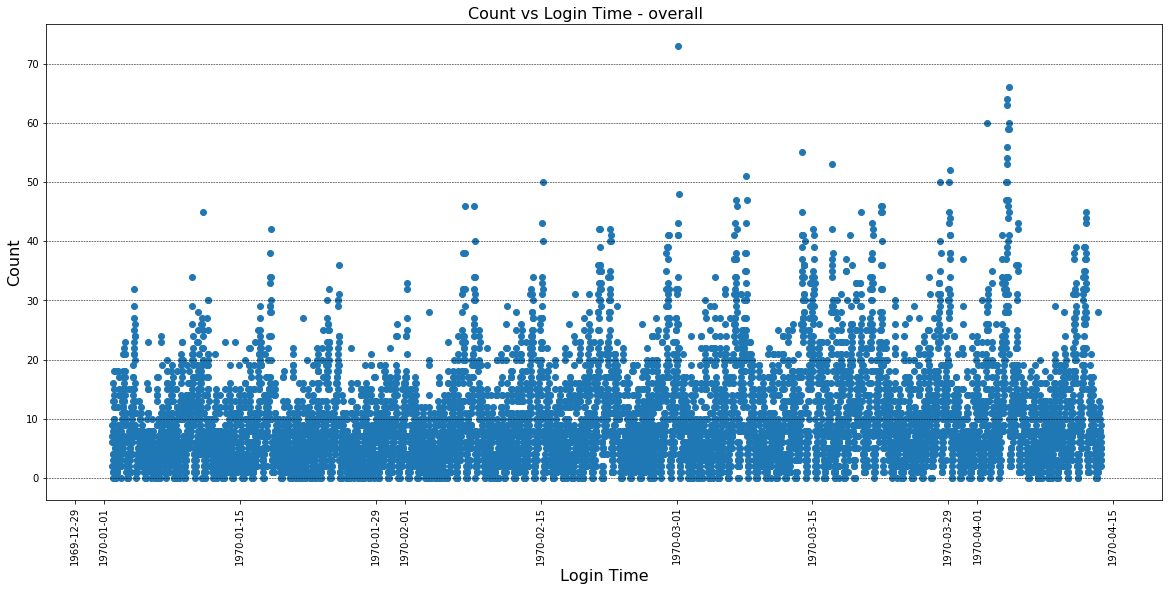

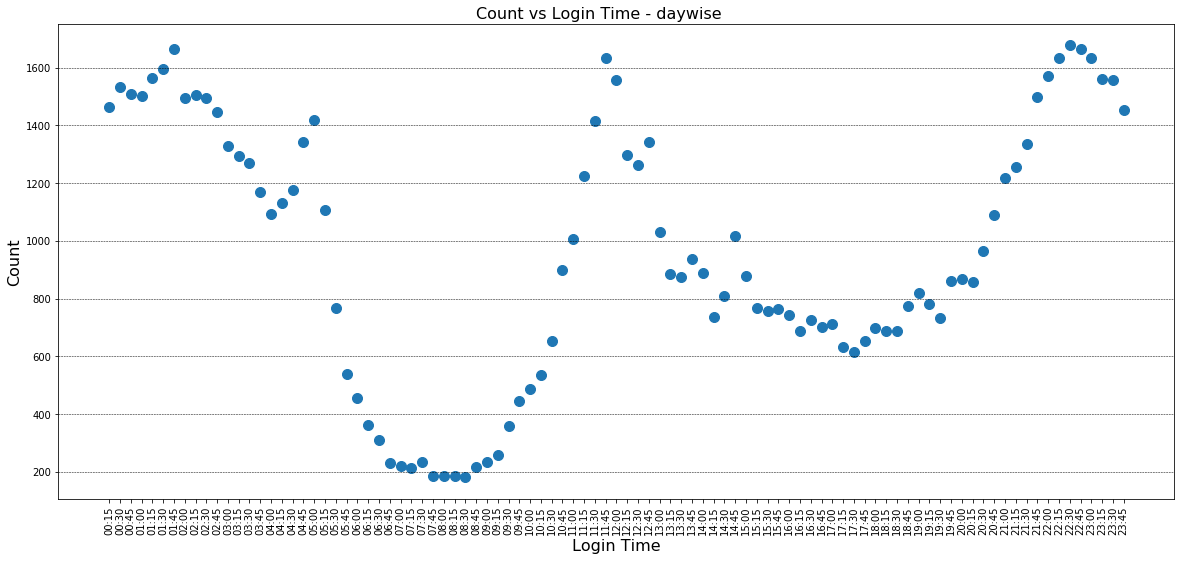

In [27]:
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
ax.scatter(full_grouped_15min.login_time, full_grouped_15min.count_time)
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Login Time', fontsize = 16)
ax.set_xlim('1969-12-26','1970-04-20' )
ax.set_ylabel('Count', fontsize = 16)
fig.suptitle('Count vs Login Time - overall', fontsize=16)
plt.xticks(rotation=90)
fig.subplots_adjust(top=0.95)
plt.show()

fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
ax.scatter(day_grouped_15min['HH:MM'], day_grouped_15min.count_time, s=100)
ax.yaxis.grid(which='major', linestyle='--', linewidth='0.5', color='black')
ax.set_xlabel('Login Time', fontsize = 16)
ax.set_ylabel('Count', fontsize = 16)
fig.suptitle('Count vs Login Time - daywise', fontsize=16)
plt.xticks(rotation=90)
fig.subplots_adjust(top=0.95)
plt.show()


1. Login patterns were aggregated over (1) 15 minute intervals for the entire period as well as (2) 15 minute intervals over time during the day
2. Although the scatter plot of the 15 minute aggregated data over entire period was hard to read, cyclical trends were indeed noticed. When this was resolved into a day long cycle, those trends became more evident with peaks noted around midnight and noon - possibly around peak of night-life in the city and lunch time. The data can be further resolved into a week long cycle to segment weekdays and weekends but was not done here.
3. One quality issue with this dataset is that it is reported to be from 1970, which is most likely a dummy year value. This in a way restricts some analyses such as segmentation by weekday/weekend as that information can be known only if the exact date is known.

# Part 2: Experiment and metrics design

### Metric(s) of choice:

If the experiemnt is to test whether drivers serve both cities instead of just one, the obvious metric of choice would be the "reimbursement amount". Because that will provide a direct estimate of how many inter-city rides happened. However, assuming that there are no reimbursements prior to this experiment, the total reimbursed amount will always be greater than zero. Hence a meaningful statistical test with reimbursement amount cannot be performed. Of course, if the reimbursement amount exceeds all prior expectations, then of course the experiment can be termed as a success.

But it is worthwhile to take a more holistic approach - is this change truly beneficial to users and the company? For that the following two metrics can be considered:

1. Distance covered: Baseline conditions indicate the rides are concentrated in the individual cities. Hence if there is more cross-connection, it can be hypothesized that the total distance covered will now be greater.
2. Number of logins/rides: Because cross-connection will be encouraged, more riders will opt for this service (as opposed to other modes of transport), when traveling inter-city
3. Profit: True measure of success of the experiment for the company


### Design of experiment:

We need to decide on a time period for this experiment - let us say 6 months. It will be setup such that neither the drivers or the riders will actually have to "claim" reimbursement. More documentation may serve as a deterrent and introduce another variable - which is not what we want. A trip_ID an possibly be generated every time someone starts a ride and that can be checked at the toll-center and if it passes the check, the toll will be waived.

Under these conditions, normal operations should be conducted and metrics should be recorded.

After the end of the test period, a two-sample one-sided t-test can be performed for statistical significance on the metrics of choice. Null and alternate hypothesis for the metrics in question are listed as follows:
1. Mean distance covered (per ride) during the experiment is equal to that observed under baseline conditions. Althernate hypothesis: the former is GREATER than the latter
2. Number of logins/rides normalized by day during the experiment is equal to that observed under baseline conditions. Alternate hypothesis: the former is GREATER than the latter. This can be split by weekday/weekend.
3. Net profit is greater during the experiment - this will be an absolute value and will not need a t-test.


### Final evalutation:

We can evaluate the success on the basis of the results of the statistical tests. If the alternate hypotheses end up being accepted, then definitely, the experiment would be a success. In case the null hypothesis is accepted, a more detailed investigation needs to be carried out. Following are some of the caveats which can potentially impact the results. Ideally the period of the experiments should account for all these scenarios.
- Weather conditions
- Natural disasters
- Major political/sporting events
- Holidays
- School/College schedules
- Need for intercity travel

Trip ride routes can also serve as a visual check to see how many intercity rides are happening - and what are the most frequented areas when an intercity ride is completed

# Part 3: Predictive modeling

First step is to read the data and classify whether the user is retained or not. For that the threshold of 30 days was applied to the last trip recorded overall - which was on Jul 01. So essentially, any user which have not had a trip post Jun 1, will be recorded as lost (0) - else they will be recorded as retained (1). Rest of the data clean-up is reported in the following cell

In [28]:
tqdm.pandas()
with open(r'D:\VirajScripts\misc_2\ultimate_data_challenge.json') as f:
    data_json = json.load(f)
user_df = pd.DataFrame(data_json)
user_df['last_trip_date'] = pd.to_datetime(user_df['last_trip_date'], errors='coerce')
user_df['signup_date'] = pd.to_datetime(user_df['signup_date'], errors='coerce')

threshold = max(user_df.last_trip_date) - timedelta(days=30)
user_df['retained'] = user_df['last_trip_date'].apply(lambda x: 1 if x>=threshold else 0)
user_df['ultimate_black_int'] = user_df['ultimate_black_user'].apply(lambda x: 1 if x == True else 0)
user_df['phone_int'] = user_df['phone'].apply(lambda x: 1 if x == 'iPhone' else (2 if x == 'Android' else 3))
user_df['city_int'] = user_df['city'].apply(lambda x: 1 if x == 'Astapor' else (2 if x == "King's Landing"  else 3))
user_df['sign_up_delta'] = pd.DatetimeIndex(user_df['signup_date']).day

display(user_df.head(10))
#user_df['sign_up_date_delta'] = user_df['signup_date'] - min(user_df.signup_date)

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,retained,ultimate_black_int,phone_int,city_int,sign_up_delta
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2,1,1,1,2,25
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0,0,0,2,1,29
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0,0,0,1,1,6
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0,1,1,1,2,10
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4,0,0,2,3,27
5,10.56,5.0,3.5,1.00,Winterfell,2014-06-06,iPhone,2014-01-09,0.0,2,True,100.0,1,1,1,3,9
6,3.95,4.0,NaN,1.00,Astapor,2014-01-25,Android,2014-01-24,0.0,1,False,100.0,0,0,2,1,24
7,2.04,5.0,5.0,1.00,Winterfell,2014-01-29,iPhone,2014-01-28,0.0,2,False,100.0,0,0,1,3,28
8,4.36,5.0,4.5,1.00,Winterfell,2014-02-01,Android,2014-01-21,0.0,2,False,100.0,0,0,2,3,21
9,2.37,5.0,NaN,1.00,Winterfell,2014-01-05,Android,2014-01-03,0.0,1,False,0.0,0,0,2,3,3


In [29]:
user_df_final = user_df[['city_int', 'trips_in_first_30_days', 'sign_up_delta', 'avg_rating_of_driver',
       'avg_surge', 'phone_int', 'surge_pct',
       'ultimate_black_int', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver', 'retained']]
display(user_df_final.head(10))
display(user_df_final.info())

"""
Although removing NaN entries from driver/rider ratings is one approach, it is possible that those ratings may not be
significant to the final model. In such a case, we will lose valuable data. We will use an average rating value as a 
substitute
"""
user_df_final = user_df_final.fillna(user_df_final.mean())
display(user_df_final.info())


,city_int,trips_in_first_30_days,sign_up_delta,avg_rating_of_driver,avg_surge,phone_int,surge_pct,ultimate_black_int,weekday_pct,avg_dist,avg_rating_by_driver,retained
0,2,4,25,4.7,1.10,1,15.4,1,46.2,3.67,5.0,1
1,1,0,29,5.0,1.00,2,0.0,0,50.0,8.26,5.0,0
2,1,3,6,4.3,1.00,1,0.0,0,100.0,0.77,5.0,0
3,2,9,10,4.6,1.14,1,20.0,1,80.0,2.36,4.9,1
4,3,14,27,4.4,1.19,2,11.8,0,82.4,3.13,4.9,0
5,3,2,9,3.5,1.00,1,0.0,1,100.0,10.56,5.0,1
6,1,1,24,NaN,1.00,2,0.0,0,100.0,3.95,4.0,0
7,3,2,28,5.0,1.00,1,0.0,0,100.0,2.04,5.0,0
8,3,2,21,4.5,1.00,2,0.0,0,100.0,4.36,5.0,0
9,3,1,3,NaN,1.00,2,0.0,0,0.0,2.37,5.0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city_int                  50000 non-null int64
trips_in_first_30_days    50000 non-null int64
sign_up_delta             50000 non-null int64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
phone_int                 50000 non-null int64
surge_pct                 50000 non-null float64
ultimate_black_int        50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
retained                  50000 non-null int64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
city_int                  50000 non-null int64
trips_in_first_30_days    50000 non-null int64
sign_up_delta             50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone_int                 50000 non-null int64
surge_pct                 50000 non-null float64
ultimate_black_int        50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
retained                  50000 non-null int64
dtypes: float64(6), int64(6)
memory usage: 4.6 MB


None

### Exploratory Data Analysis

Following independent variables will be tested for significance:
1. City: if there is a particular city where driver retention is high/low
City 2 has a higher retention rate than the other cities do
   
2. Trips in first 30 days: Initial usage can be a strong indicator of driver retention probability
There is a subtle difference between the curves - distribution for retained customers has a longer tail
   
3. Weekday pct
Again, only a subtle difference between curves
   
4. Avg distance: This variable can determine driver retention
Retained customers have a (marginally) longer distance traveled

5. Avg Surge/Surge_pct
Stark difference between retained and non-retained users

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


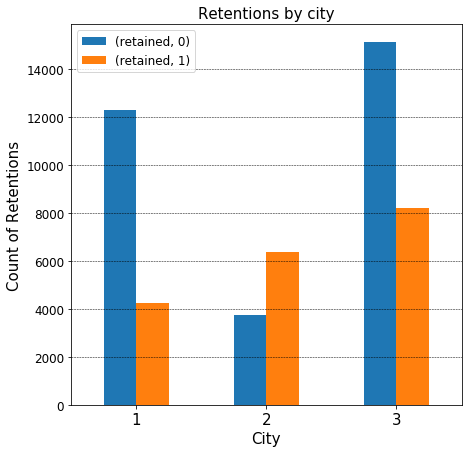

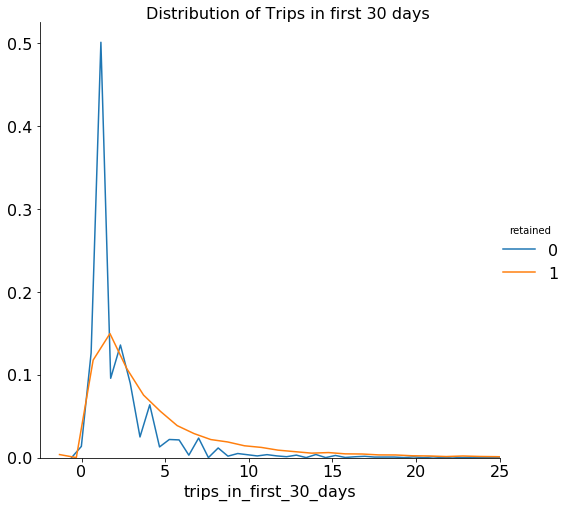

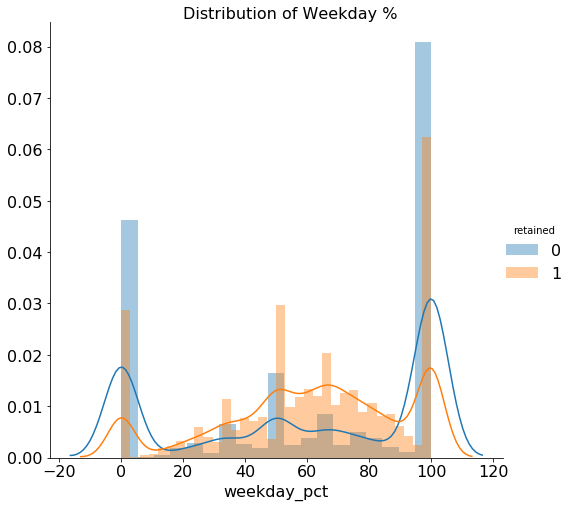

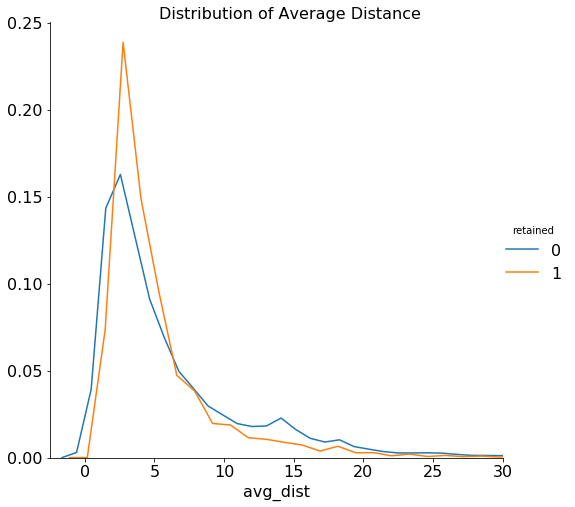

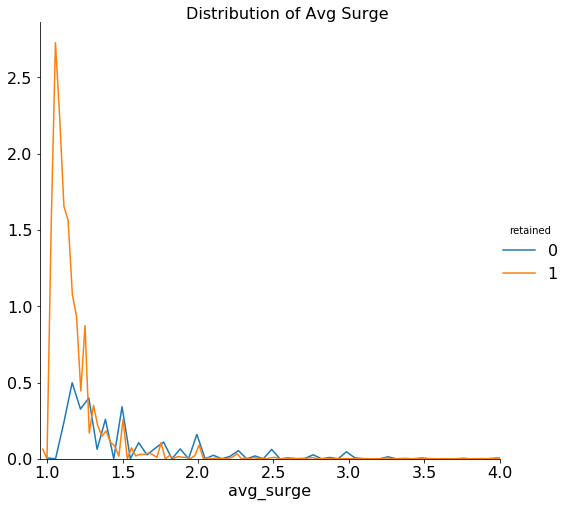

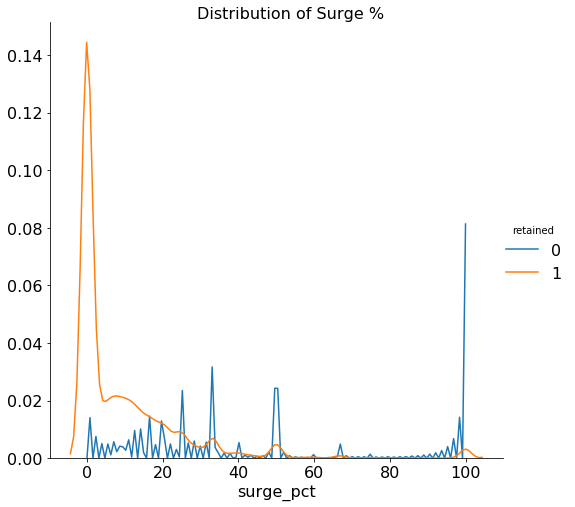

In [30]:
# City
fig, ax = plt.subplots()
fig.set_figheight(7)
fig.set_figwidth(7)
user_df_final.groupby('city_int')['retained'].value_counts(normalize=False).to_frame().unstack().plot(ax=ax, kind='bar')
ax.grid(which='major', axis='y', linestyle='--', linewidth='0.5', color='black')
ax.legend(loc = 'upper left', prop={'size': 12});
ax.yaxis.set_tick_params(labelsize=12)
ax.set_ylabel('Count of Retentions', fontsize=15)
ax.xaxis.set_tick_params(rotation=0, labelsize=15)
ax.set_xlabel('City', fontsize=15)
ax.set_title('Retentions by city', fontsize=15);

# Trips in first 30 days
g = sns.FacetGrid(user_df_final, hue = "retained", size=7)
g = (g.map(sns.distplot, "trips_in_first_30_days", hist=False).add_legend(fontsize=16))
g.set_titles(size=16)
for ax in g.axes.flat:
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_xlim(-2.5, 25)    
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Distribution of Trips in first 30 days',fontsize=16);

# Weekday percentage
g = sns.FacetGrid(user_df_final, hue = "retained", size=7)
g = (g.map(sns.distplot, "weekday_pct").add_legend(fontsize=16))
g.set_titles(size=16)
for ax in g.axes.flat:
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)    
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Distribution of Weekday %',fontsize=16);

# Average Distance
g = sns.FacetGrid(user_df_final, hue = "retained", size=7)
g = (g.map(sns.distplot, "avg_dist", hist=False).add_legend(fontsize=16))
g.set_titles(size=16)
for ax in g.axes.flat:
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16) 
    ax.set_xlim(-2.5, 30)
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Distribution of Average Distance',fontsize=16);

# Average Surge
g = sns.FacetGrid(user_df_final, hue = "retained", size=7)
g = (g.map(sns.distplot, "avg_surge", hist=False).add_legend(fontsize=16))
g.set_titles(size=16)
for ax in g.axes.flat:
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_xlim(0.95, 4)    
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Distribution of Avg Surge',fontsize=16);

# Surge Pct
g = sns.FacetGrid(user_df_final, hue = "retained", size=7)
g = (g.map(sns.distplot, "surge_pct", hist=False).add_legend(fontsize=16))
g.set_titles(size=16)
for ax in g.axes.flat:
    ax.yaxis.set_tick_params(labelsize=16)
    ax.xaxis.set_tick_params(labelsize=16)
    ax.set_title(ax.get_title(), fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16) 
g.fig.subplots_adjust(top=.95)
g.fig.suptitle('Distribution of Surge %',fontsize=16);

### Predictive modeling - Random Forests

Random forests were chosen as they are the first choice and an industry standard. In this case, ideally we want to catch the non-retained customers. So the recall of class 0 should be maximum. The Random Forest model results in a Class 0 recall of 87%, which may be acceptable based on the threshold decided by Ultimate Inc.

Once this is identified, Ultimate Inc can then devise a strategy to retain those customers, which the model predicts as likely to leave.

For example, a feature importance analysis shows that the most important features are:
1. Average Rating by Driver
2. Weekday %
3. Surge %
4. City

Following strategies can be employed to address these issues:
Conduct driver surveys to get more information on the users - to explore possibility of conflict/behavioral issues
Explore the option of different rates for weekdays/weekends. Based on the model, higher the weekday % usage, higher likelihood of user being retained
Target users of the city which is most likely to lose users with marketing strategies, promotions, etc.

Following is the information on our dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
city_int                  50000 non-null int64
trips_in_first_30_days    50000 non-null int64
sign_up_delta             50000 non-null int64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
phone_int                 50000 non-null int64
surge_pct                 50000 non-null float64
ultimate_black_int        50000 non-null int64
weekday_pct               50000 non-null float64
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
dtypes: float64(6), int64(5)
memory usage: 4.2 MB
None
Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  2.0min remaining:  1.3min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


model building took 200 seconds

Training data set score is 0.845925

Best hyperparameters are

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=25, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=7, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=2000, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

Test data set score is 0.7819

Classification Report

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6219
           1       0.74      0.65      0.69      3781

   micro avg       0.78      0.78      0.78     10000
   macro avg       0.77      0.76      0.76     10000
weighted avg       0.78      0.78      0.78     10000

Confusion Matrix



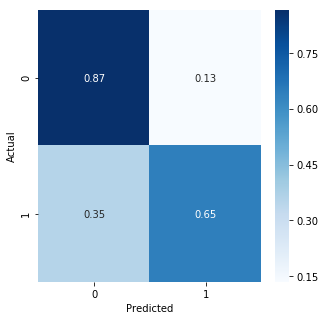

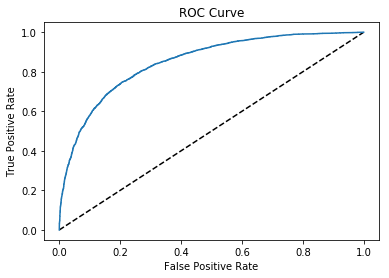

In [33]:
start = datetime.datetime.now()
# Test-Train split
X_Full = user_df_final[['city_int', 'trips_in_first_30_days', 'sign_up_delta', 'avg_rating_of_driver',
       'avg_surge', 'phone_int', 'surge_pct',
       'ultimate_black_int', 'weekday_pct', 'avg_dist',
       'avg_rating_by_driver']]
y_Full = user_df_final[['retained']]

print("Following is the information on our dataset\n")
print(X_Full.info())

X_train, X_test,y_train, y_test = train_test_split(X_Full, y_Full, test_size=0.2, random_state=42)

# Build Random Forest Classifier
rf = RandomForestClassifier(random_state = 42)
param_grid = {
            'bootstrap': [True],
            'max_depth': [25,30],
            'min_samples_leaf': [6,7],
            'min_samples_split': [2],
            'n_estimators': [2000]
            }
gs = sklearn.model_selection.GridSearchCV(estimator = rf, param_grid = param_grid, n_jobs = -1, verbose = 2, cv=5)
gs_results = gs.fit(X_train,y_train.values.ravel())
best_grid = gs_results.best_estimator_

end = datetime.datetime.now()
print('model building took {} seconds'.format((end-start).seconds))

## Training Score
print('\nTraining data set score is {}\n'.format(accuracy_score(best_grid.predict(X_train),y_train)))

## Hyperparameter and test score
print("Best hyperparameters are\n")
print(best_grid)
print('\nTest data set score is {}\n'.format(accuracy_score(best_grid.predict(X_test),y_test)))

## Classification report
print('Classification Report\n')
print(classification_report(y_test,best_grid.predict(X_test)))

## Confustion matrix
print('Confusion Matrix\n')
#labels = ['run', 'pass']
confmat = confusion_matrix(y_test, best_grid.predict(X_test))
confmat_n = confmat.astype('float')/confmat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(5,5))
sns.heatmap(confmat_n, annot=True, fmt='.2f', cmap='Blues', ax=ax)
ax.set_ylabel('Actual')
ax.set_xlabel('Predicted')
ax.axhspan  
plt.savefig('Conf_mat_RF.png')

## ROC Curve
y_pred_prob = best_grid.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
fig, ax = plt.subplots()
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve');
plt.savefig('ROC_RF.png')

In [37]:
## Feature Importance
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), best_grid.feature_importances_), X_train.columns), 
             reverse=True))

Features sorted by their score:
[(0.1528, 'avg_rating_by_driver'), (0.1366, 'weekday_pct'), (0.1157, 'surge_pct'), (0.1128, 'city_int'), (0.0999, 'avg_dist'), (0.085, 'avg_surge'), (0.0691, 'trips_in_first_30_days'), (0.0659, 'sign_up_delta'), (0.0644, 'phone_int'), (0.0543, 'ultimate_black_int'), (0.0436, 'avg_rating_of_driver')]
